--- [Langkah 1] Menginstal Library (Transformers & Sastrawi) ---
✅ Instalasi Selesai.

--- [Langkah 2] Mengimpor Library & Menyiapkan Alat ---
✅ Semua library siap.

--- [Langkah 3] Memuat Dataset 'data_balanced_500.csv' ---
Mounted at /content/drive
File /content/drive/MyDrive/data_balanced_500.csv berhasil dimuat.
Total data setelah dibersihkan (dari NaN): 834 baris

✅ Data siap untuk diproses.

--- [Langkah 3.1] Exploratory Data Analysis (EDA) ---

[EDA 1] Contoh Sample Data (Acak 5 baris):
                                              text_raw label_raw
478  Mereka saling melindungi...tak ada ketegasan d...   negatif
676               Sangat kejam dan tidak manusiawi itu   negatif
307              Harus nya nyawa di balas dengan nyawa   negatif
286          Semangat selalu untuk keluarga 😢😢😢😢😢😢😢😢😢❤   positif
770  Hukum mati tu polisi bw langsung ke Nusa kemba...   negatif

[EDA 2] Distribusi Label/Kelas (Positif vs Negatif):


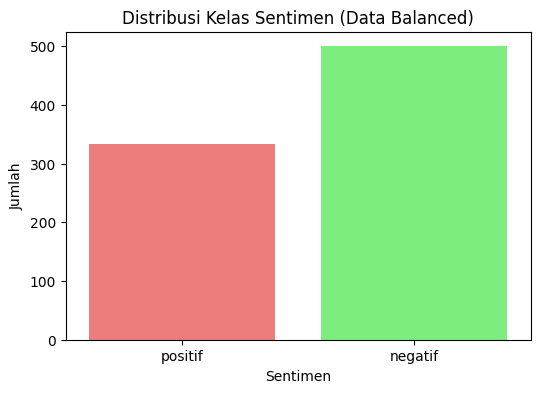


[EDA 3] Histogram Fitur Numerik (Panjang Teks):


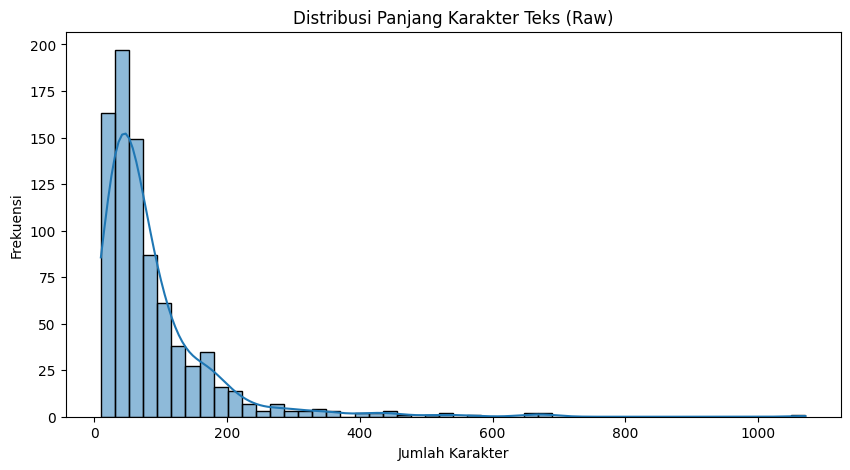

<Figure size 1000x500 with 0 Axes>

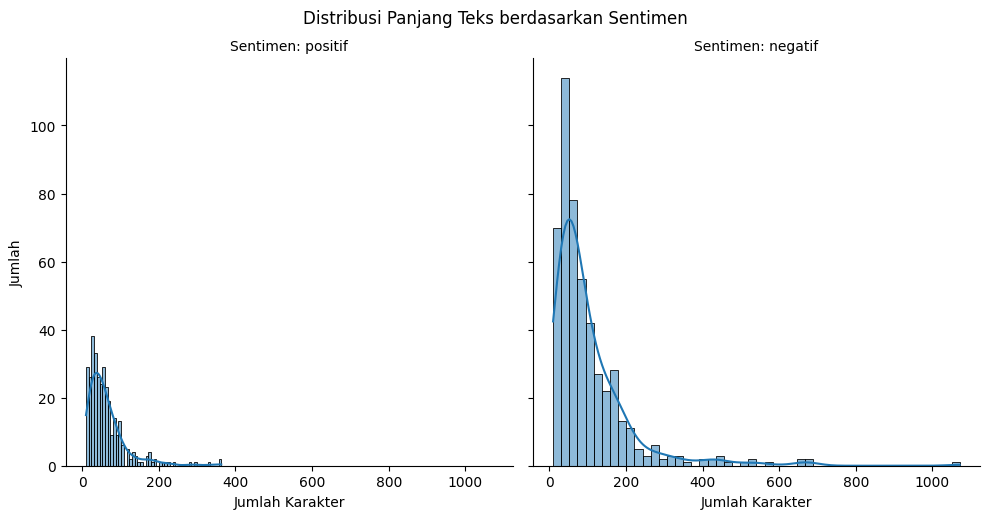


[EDA 4] Korelasi Antar Fitur:
   -> Catatan: Analisis korelasi (heatmap) tidak relevan pada tahap ini.

--- [Langkah 4] Fungsi 'clean_text_for_bert' (versi ringan) berhasil dibuat ---

--- [Langkah 5] Memulai proses text preprocessing ringan ---
✅ Proses preprocessing selesai.

--- [Langkah 6] Membagi Data & Ekstraksi Fitur (IndoBERT) ---
Data Latih (Train): 667 baris teks
Data Uji (Test): 167 baris teks
Menggunakan device: cpu
PERINGATAN: WAJIB AKTIFKAN GPU! (Runtime -> Change runtime type -> T4 GPU)
Model IndoBERT (untuk embedding) berhasil dimuat.

Memulai ekstraksi embedding untuk Data Latih... (Proses Lambat ☕)


Getting Embeddings:   0%|          | 0/21 [00:00<?, ?it/s]

Ekstraksi Data Latih Selesai. Shape: (667, 768)

Memulai ekstraksi embedding untuk Data Uji... (Proses Lambat ☕)


Getting Embeddings:   0%|          | 0/6 [00:00<?, ?it/s]

Ekstraksi Data Uji Selesai. Shape: (167, 768)

--- [Langkah 7] Memulai pelatihan model Random Forest... 🌳🌳🌳 ---
✅ Pelatihan model SELESAI.

--- [Langkah 7.1] Menyimpan model (RF) ke Google Drive ---
Model berhasil disimpan di: /content/drive/MyDrive/rf_bert_model_PosNeg.joblib


--- [Langkah 8] LAPORAN EVALUASI AKHIR (IndoBERT + RF) ---

Total Sampel Uji: 167
Akurasi (Accuracy):      91.02%

--- Laporan Klasifikasi (per kelas) ---
              precision    recall  f1-score   support

     negatif       0.89      0.97      0.93       100
     positif       0.95      0.82      0.88        67

    accuracy                           0.91       167
   macro avg       0.92      0.90      0.90       167
weighted avg       0.91      0.91      0.91       167


--- [Langkah 9] GRAFIK CONFUSION MATRIX (2x2) ---
Grafik 'eval_confusion_matrix.png' dibuat.


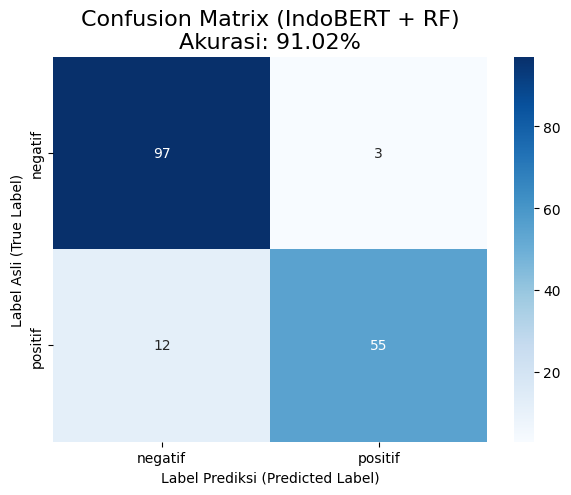


--- [Langkah 9.1] GRAFIK ROC CURVE ---
Grafik 'eval_roc_curve.png' dibuat.


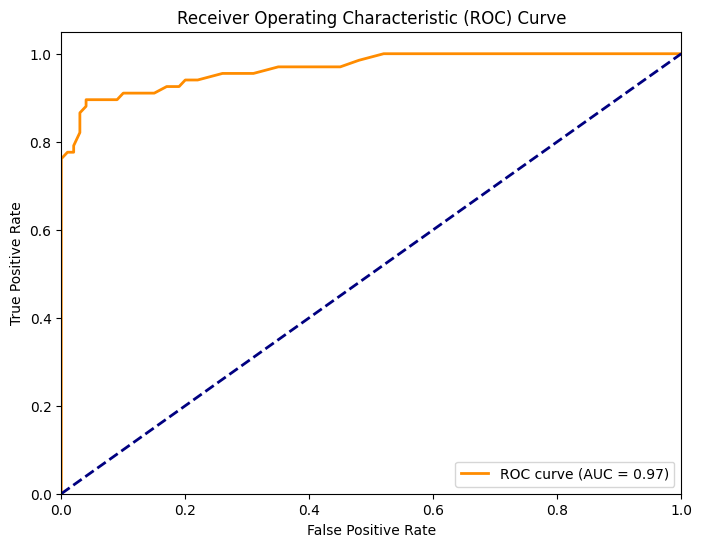


--- [Langkah 9.2] GRAFIK PRECISION-RECALL CURVE ---
Grafik 'eval_pr_curve.png' dibuat.


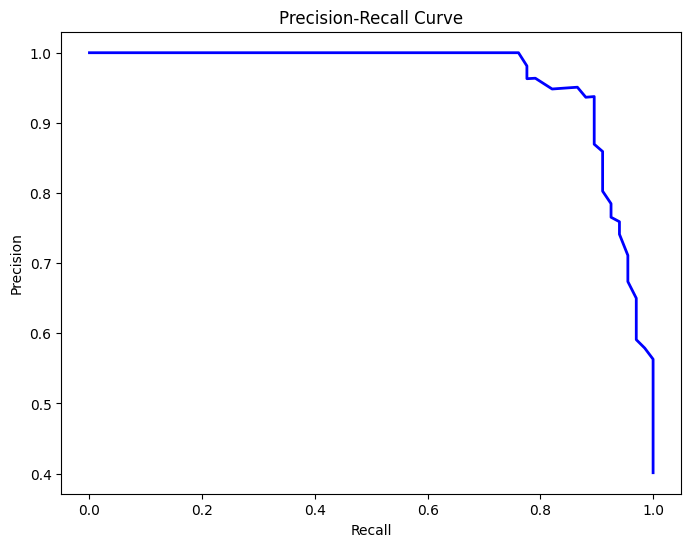


--- [Langkah 9.3] GRAFIK DISTRIBUSI PROBABILITAS PREDIKSI ---
Grafik 'eval_distribusi_probabilitas.png' dibuat.


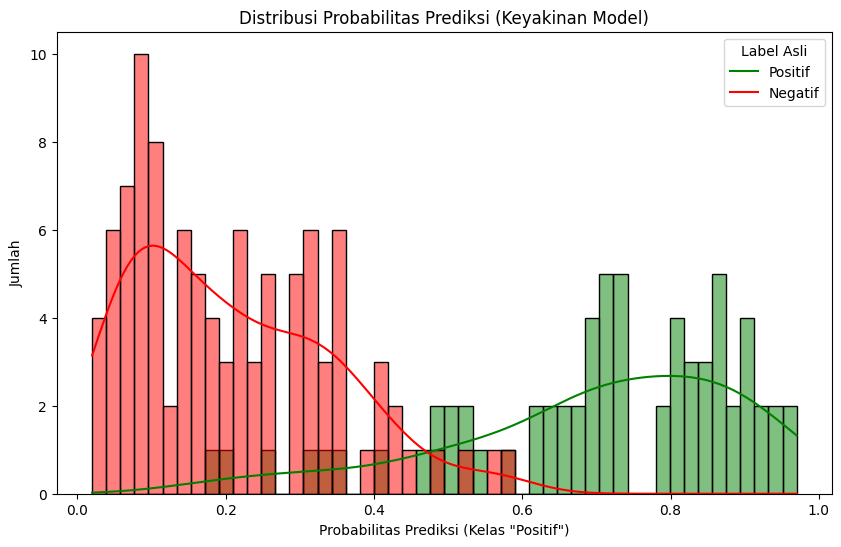


--- [Langkah 9.4] GRAFIK LEARNING CURVE ---
Membuat Learning Curve... (Ini mungkin perlu waktu beberapa saat)
Grafik 'eval_learning_curve.png' dibuat.


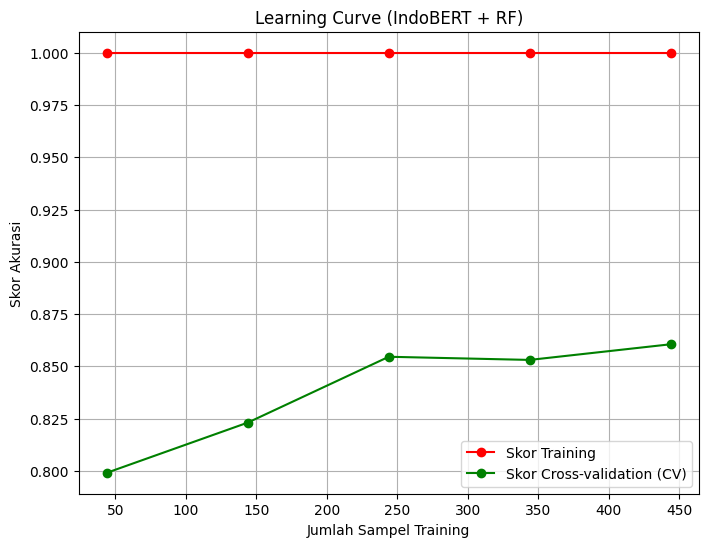



--- [Langkah 10] CONTOH PREDIKSI DENGAN MODEL BARU ---

Memprediksi 4 teks baru:
Memuat model IndoBERT (500MB) untuk prediksi...
Membersihkan teks...
Mendapatkan embeddings dari BERT...
Memprediksi dengan RandomForest...
  Teks: 'polisi itu sangat membantu warga, terima kasih'  -->  Prediksi: positif
  Teks: 'tindakan brimob itu brutal dan tidak manusiawi'  -->  Prediksi: negatif
  Teks: 'bangsat polisi k=pukimak'  -->  Prediksi: negatif
  Teks: 'saya suka sekali pelayanan di kantor polisi itu'  -->  Prediksi: negatif


--- SEMUA LANGKAH SELESAI ---


In [38]:
# --- Langkah 1: Instalasi Library ---
print("--- [Langkah 1] Menginstal Library (Transformers & Sastrawi) ---")
# Menambahkan transformers dan torch
!pip install Sastrawi pandas scikit-learn nltk seaborn transformers torch -q
print("✅ Instalasi Selesai.")


# --- Langkah 2: Import Library & Setup ---
print("\n--- [Langkah 2] Mengimpor Library & Menyiapkan Alat ---")
import pandas as pd
import re
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from tqdm.auto import tqdm
import numpy as np # <-- [TAMBAHAN] Diperlukan untuk Learning Curve

# Import Scikit-learn (Tetap dipakai)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- [BARU] Import untuk Grafik Evaluasi Tambahan ---
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import learning_curve

# --- [BARU] Import untuk BERT ---
import torch
from transformers import BertTokenizer, BertModel

# (Sastrawi & NLTK tidak lagi digunakan untuk preprocessing BERT)
# Inisialisasi tqdm untuk progress bar di pandas
tqdm.pandas()
print("✅ Semua library siap.")


# --- Langkah 3: Muat & Persiapkan Dataset ---
print("\n--- [Langkah 3] Memuat Dataset 'data_balanced_500.csv' ---")

# Hubungkan Google Drive
try:
    drive.mount('/content/drive', force_remount=True)
except Exception as e:
    print(f"Error saat mount drive: {e}")

PATH_FILE = '/content/drive/MyDrive/data_balanced_500.csv'
df = None
label_names = []

try:
    df = pd.read_csv(PATH_FILE)
    print(f"File {PATH_FILE} berhasil dimuat.")

    NAMA_KOLOM_TEKS = 'text'
    NAMA_KOLOM_LABEL = 'sentiment'
    df = df.rename(columns={
        NAMA_KOLOM_TEKS: 'text_raw',
        NAMA_KOLOM_LABEL: 'label_raw'
    })
    df = df.dropna(subset=['text_raw', 'label_raw'])
    print(f"Total data setelah dibersihkan (dari NaN): {len(df)} baris")

    # ENCODING LABEL (String -> Angka)
    df['label_raw'] = df['label_raw'].astype(str).str.lower()
    label_map = {'negatif': 0, 'positif': 1}
    label_names = ['negatif', 'positif']
    df['label_encoded'] = df['label_raw'].map(label_map)
    df = df.dropna(subset=['label_encoded'])
    df['label_encoded'] = df['label_encoded'].astype(int)

    print("\n✅ Data siap untuk diproses.")

except Exception as e:
    print(f"\nTerjadi error saat memuat data: {e}")


# --- [BARU] Langkah 3.1: Exploratory Data Analysis (EDA) ---
if df is not None:
    print("\n--- [Langkah 3.1] Exploratory Data Analysis (EDA) ---")

    # 1. Contoh Sample Data
    print("\n[EDA 1] Contoh Sample Data (Acak 5 baris):")
    print(df[['text_raw', 'label_raw']].sample(5))

    # 2. Distribusi Label/Kelas
    print("\n[EDA 2] Distribusi Label/Kelas (Positif vs Negatif):")
    plt.figure(figsize=(6, 4))
    sns.countplot(x='label_raw', data=df, palette=['#FF6B6B', '#6BFF6B'])
    plt.title('Distribusi Kelas Sentimen (Data Balanced)')
    plt.xlabel('Sentimen')
    plt.ylabel('Jumlah')
    plt.savefig('eda_distribusi_label.png')
    plt.show()

    # 3. Histogram Fitur Numerik (Panjang Teks)
    print("\n[EDA 3] Histogram Fitur Numerik (Panjang Teks):")
    df['panjang_teks'] = df['text_raw'].astype(str).apply(len)

    plt.figure(figsize=(10, 5))
    sns.histplot(df['panjang_teks'], bins=50, kde=True)
    plt.title('Distribusi Panjang Karakter Teks (Raw)')
    plt.xlabel('Jumlah Karakter')
    plt.ylabel('Frekuensi')
    plt.savefig('eda_distribusi_panjang_teks.png')
    plt.show()

    # Bonus: Plot panjang teks dipisahkan berdasarkan sentimen
    plt.figure(figsize=(10, 5))
    g = sns.FacetGrid(df, col='label_raw', height=5)
    g.map(sns.histplot, 'panjang_teks', bins=50, kde=True)
    g.set_axis_labels("Jumlah Karakter", "Jumlah")
    g.set_titles("Sentimen: {col_name}")
    plt.suptitle('Distribusi Panjang Teks berdasarkan Sentimen', y=1.03)
    plt.savefig('eda_distribusi_panjang_teks_by_sentimen.png')
    plt.show()

    # 4. Korelasi Antar Fitur (Penjelasan)
    print("\n[EDA 4] Korelasi Antar Fitur:")
    print("   -> Catatan: Analisis korelasi (heatmap) tidak relevan pada tahap ini.")

else:
    print("\n[Langkah 3.1] EDA Dilewati karena data gagal dimuat.")


# --- Langkah 4: Fungsi Text Preprocessing (VERSI RINGAN UNTUK BERT) ---
def clean_text_for_bert(text):
    """Fungsi pembersihan ringan, HANYA hapus URL/Mention/spasi berlebih."""
    if not isinstance(text, str):
        return ""
    text = text.lower() # Case Folding
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

print("\n--- [Langkah 4] Fungsi 'clean_text_for_bert' (versi ringan) berhasil dibuat ---")


# --- Langkah 5: Terapkan Preprocessing ke Data ---
if df is not None:
    print("\n--- [Langkah 5] Memulai proses text preprocessing ringan ---")
    df['text_clean'] = df['text_raw'].apply(clean_text_for_bert)
    print("✅ Proses preprocessing selesai.")
else:
    print("\n[Langkah 5] Dilewati karena data gagal dimuat di Langkah 3.")


# --- Langkah 6: Split Data & Ekstraksi Fitur (INDOBERT EMBEDDING) ---
if df is not None and 'text_clean' in df.columns:
    print("\n--- [Langkah 6] Membagi Data & Ekstraksi Fitur (IndoBERT) ---")
    X = df['text_clean']
    y = df['label_encoded']
    X_train_text, X_test_text, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=42,
                                                        stratify=y)
    print(f"Data Latih (Train): {len(X_train_text)} baris teks")
    print(f"Data Uji (Test): {len(X_test_text)} baris teks")

    # --- Setup Device & Load IndoBERT ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Menggunakan device: {device}")
    if device.type == 'cpu':
        print("PERINGATAN: WAJIB AKTIFKAN GPU! (Runtime -> Change runtime type -> T4 GPU)")
    MODEL_NAME = 'indobenchmark/indobert-base-p1'
    tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
    bert_model = BertModel.from_pretrained(MODEL_NAME).to(device)
    bert_model.eval()
    print("Model IndoBERT (untuk embedding) berhasil dimuat.")

    # --- Fungsi Embedding (Mean Pooling) ---
    def get_bert_embeddings(texts, batch_size=32):
        """Mengubah daftar teks menjadi embedding (vektor 768 dimensi)."""
        all_embeddings = []
        for i in tqdm(range(0, len(texts), batch_size), desc="Getting Embeddings"):
            batch_texts = list(texts[i:i+batch_size])
            inputs = tokenizer(batch_texts,
                               return_tensors='pt',
                               truncation=True,
                               padding=True,
                               max_length=128).to(device)
            with torch.no_grad():
                outputs = bert_model(**inputs)
            last_hidden_states = outputs.last_hidden_state
            attention_mask = inputs['attention_mask']
            mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_states.size()).float()
            sum_embeddings = torch.sum(last_hidden_states * mask_expanded, 1)
            sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
            mean_embeddings = (sum_embeddings / sum_mask).cpu().numpy()
            all_embeddings.append(mean_embeddings)
        return np.concatenate(all_embeddings, axis=0)

    # --- Ekstraksi Fitur (Proses Lambat, BUTUH GPU) ---
    print("\nMemulai ekstraksi embedding untuk Data Latih... (Proses Lambat ☕)")
    X_train_vec = get_bert_embeddings(X_train_text.tolist())
    print(f"Ekstraksi Data Latih Selesai. Shape: {X_train_vec.shape}")

    print("\nMemulai ekstraksi embedding untuk Data Uji... (Proses Lambat ☕)")
    X_test_vec = get_bert_embeddings(X_test_text.tolist())
    print(f"Ekstraksi Data Uji Selesai. Shape: {X_test_vec.shape}")
else:
    print("\n[Langkah 6] Dilewati karena preprocessing gagal.")


# --- Langkah 7: Training Model Random Forest ---
if 'X_train_vec' in locals():
    print("\n--- [Langkah 7] Memulai pelatihan model Random Forest... 🌳🌳🌳 ---")
    rf_model = RandomForestClassifier(n_estimators=100,
                                      random_state=42,
                                      class_weight='balanced',
                                      n_jobs=-1)
    rf_model.fit(X_train_vec, y_train)
    print("✅ Pelatihan model SELESAI.")

    # --- [Langkah 7.1] Menyimpan Model Hasil Pelatihan ---
    print("\n--- [Langkah 7.1] Menyimpan model (RF) ke Google Drive ---")
    try:
        save_directory = os.path.dirname(PATH_FILE)
        model_path = os.path.join(save_directory, 'rf_bert_model_PosNeg.joblib')
        joblib.dump(rf_model, model_path)
        print(f"Model berhasil disimpan di: {model_path}")
    except Exception as e:
        print(f"!!! ERROR saat menyimpan model: {e} !!!")
else:
    print("\n[Langkah 7] Dilewati karena data latih tidak siap.")


# --- Langkah 8: Laporan Evaluasi Akhir ---
if 'rf_model' in locals():
    print("\n\n" + "="*40)
    print("--- [Langkah 8] LAPORAN EVALUASI AKHIR (IndoBERT + RF) ---")
    print("="*40)

    y_pred = rf_model.predict(X_test_vec)
    # --- [BARU] Dapatkan probabilitas untuk grafik ---
    y_probs_all = rf_model.predict_proba(X_test_vec)
    y_probs_pos = y_probs_all[:, 1] # Probabilitas kelas 'positif'

    accuracy = accuracy_score(y_test, y_pred)

    print(f"\nTotal Sampel Uji: {len(y_test)}")
    print(f"Akurasi (Accuracy):      {accuracy * 100:.2f}%")
    print("\n--- Laporan Klasifikasi (per kelas) ---")
    print(classification_report(y_test, y_pred, target_names=label_names, zero_division=0))
else:
    print("\n[Langkah 8] Dilewati karena model gagal dilatih.")


# --- Langkah 9: Grafik Confusion Matrix ---
if 'rf_model' in locals():
    print("\n--- [Langkah 9] GRAFIK CONFUSION MATRIX (2x2) ---")
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index = label_names, columns = label_names)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (IndoBERT + RF)\nAkurasi: {accuracy*100:.2f}%', fontsize=16)
    plt.ylabel('Label Asli (True Label)')
    plt.xlabel('Label Prediksi (Predicted Label)')
    plt.savefig('eval_confusion_matrix.png')
    print("Grafik 'eval_confusion_matrix.png' dibuat.")
    plt.show()
else:
    print("\n[Langkah 9] Dilewati karena evaluasi gagal.")

# --- [BARU] Langkah 9.1: Grafik ROC Curve ---
if 'rf_model' in locals():
    print("\n--- [Langkah 9.1] GRAFIK ROC CURVE ---")
    fpr, tpr, thresholds = roc_curve(y_test, y_probs_pos)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Garis acak
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('eval_roc_curve.png')
    print("Grafik 'eval_roc_curve.png' dibuat.")
    plt.show()

# --- [BARU] Langkah 9.2: Grafik Precision-Recall Curve ---
if 'rf_model' in locals():
    print("\n--- [Langkah 9.2] GRAFIK PRECISION-RECALL CURVE ---")
    precision, recall, _ = precision_recall_curve(y_test, y_probs_pos)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.savefig('eval_pr_curve.png')
    print("Grafik 'eval_pr_curve.png' dibuat.")
    plt.show()

# --- [BARU] Langkah 9.3: Grafik Distribusi Probabilitas ---
if 'rf_model' in locals():
    print("\n--- [Langkah 9.3] GRAFIK DISTRIBUSI PROBABILITAS PREDIKSI ---")

    # Buat DataFrame untuk plot
    df_probs = pd.DataFrame({
        'prob_positif': y_probs_pos,
        'label_asli': y_test
    })
    # Ganti 0/1 dengan 'negatif'/'positif' untuk legenda
    df_probs['label_asli'] = df_probs['label_asli'].map({0: 'negatif', 1: 'positif'})

    plt.figure(figsize=(10, 6))
    # Plot dua histogram (satu untuk 'negatif' asli, satu untuk 'positif' asli)
    sns.histplot(data=df_probs, x='prob_positif', hue='label_asli',
                 bins=50, kde=True, palette={'negatif':'red', 'positif':'green'})
    plt.title('Distribusi Probabilitas Prediksi (Keyakinan Model)')
    plt.xlabel('Probabilitas Prediksi (Kelas "Positif")')
    plt.ylabel('Jumlah')
    plt.legend(title='Label Asli', labels=['Positif', 'Negatif'])
    plt.savefig('eval_distribusi_probabilitas.png')
    print("Grafik 'eval_distribusi_probabilitas.png' dibuat.")
    plt.show()

# --- [BARU] Langkah 9.4: Grafik Learning Curve ---
if 'rf_model' in locals():
    print("\n--- [Langkah 9.4] GRAFIK LEARNING CURVE ---")
    print("Membuat Learning Curve... (Ini mungkin perlu waktu beberapa saat)")

    try:
        # Kita gunakan X_train_vec dan y_train untuk melihat kurva belajar
        # Menggunakan cv=3 (3-fold) untuk mempercepat proses
        train_sizes, train_scores, test_scores = learning_curve(
            # Gunakan estimator dasar, bukan yang sudah di-fit
            RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1),
            X_train_vec,
            y_train,
            cv=3,
            n_jobs=-1,
            scoring='accuracy',
            train_sizes=np.linspace(0.1, 1.0, 5) # 5 titik
        )

        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)

        plt.figure(figsize=(8, 6))
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Skor Training")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Skor Cross-validation (CV)")
        plt.title('Learning Curve (IndoBERT + RF)')
        plt.xlabel('Jumlah Sampel Training')
        plt.ylabel('Skor Akurasi')
        plt.legend(loc="best")
        plt.grid()
        plt.savefig('eval_learning_curve.png')
        print("Grafik 'eval_learning_curve.png' dibuat.")
        plt.show()

    except Exception as e:
        print(f"Gagal membuat Learning Curve: {e}")


# --- [Langkah 10] Melakukan Prediksi ---
print("\n\n" + "="*40)
print("--- [Langkah 10] CONTOH PREDIKSI DENGAN MODEL BARU ---")
print("="*40)

def predict_sentiment_bert_rf(texts_to_predict):
    """Fungsi lengkap untuk memprediksi sentimen menggunakan model tersimpan."""
    MODEL_RF_PATH = '/content/drive/MyDrive/rf_bert_model_PosNeg.joblib'
    try:
        saved_rf_model = joblib.load(MODEL_RF_PATH)
        print("Memuat model IndoBERT (500MB) untuk prediksi...")
        pred_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        pred_tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
        pred_model = BertModel.from_pretrained('indobenchmark/indobert-base-p1').to(pred_device)
        pred_model.eval()
        label_map_inv = {0: 'negatif', 1: 'positif'}
        print("Membersihkan teks...")
        cleaned_texts = [clean_text_for_bert(t) for t in texts_to_predict]
        print("Mendapatkan embeddings dari BERT...")
        inputs = pred_tokenizer(cleaned_texts,
                                return_tensors='pt',
                                truncation=True,
                                padding=True,
                                max_length=128).to(pred_device)
        with torch.no_grad():
            outputs = pred_model(**inputs)
        last_hidden_states = outputs.last_hidden_state
        attention_mask = inputs['attention_mask']
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_states.size()).float()
        sum_embeddings = torch.sum(last_hidden_states * mask_expanded, 1)
        sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
        embeddings = (sum_embeddings / sum_mask).cpu().numpy()
        print("Memprediksi dengan RandomForest...")
        predictions_encoded = saved_rf_model.predict(embeddings)
        predictions_text = [label_map_inv[p] for p in predictions_encoded]
        return list(zip(texts_to_predict, predictions_text))
    except Exception as e:
        return [f"Error saat prediksi: {e}"]

# --- Coba Prediksi ---
contoh_teks = [
    "polisi itu sangat membantu warga, terima kasih",
    "tindakan brimob itu brutal dan tidak manusiawi",
    "bangsat polisi k=pukimak",
    "saya suka sekali pelayanan di kantor polisi itu"
]
print(f"\nMemprediksi {len(contoh_teks)} teks baru:")
hasil_prediksi = predict_sentiment_bert_rf(contoh_teks)
for hasil in hasil_prediksi:
    print(f"  Teks: '{hasil[0]}'  -->  Prediksi: {hasil[1]}")

print("\n\n--- SEMUA LANGKAH SELESAI ---")